<a href="https://colab.research.google.com/github/AceAltair13/facial-expression-recognition/blob/main/CNN_FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T104910Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D333b9afdef793e84a7ba9ec486c612ed6663d95e417520845a53ecd12b413bd032330edd573ae367e78598d24d91700396651b50f44e209881675b0c9521f63f947632e15c7fc6cd3e9cb7980317da167f384baa924a5f5e0d5e4da969e5cb9b895418dadefe89121bbf823a39c6a849ca51732190fcdae2bfdd1d2ec6706ad15b34f291720e95e9047e9207be1f5654f06405c1b43b12ff9592ec0317faa7fd32fabaa5e5c1adde8374daf13cbff973c3caf1e7cb122f94c6c1525e309ee093bd2d33a6eeeb3e34577222be34d6a8659c142afdcfc21bf4ab82f51207f05da18284d8a8a77802829605ae24e2ee260105219b22004fb25b0d76b751295d7950'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


# **Introduction**

The goal of this project is to develop a deep learning model that can accurately classify facial expressions into one of seven categories: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral. We will use convolutional neural networks (CNNs) to train our model, as they have been shown to be effective in image classification tasks. Our approach involves training a CNN model from scratch on the FER-2013 dataset

![emotions.png](attachment:02a21be9-12eb-4595-a450-8414036bac30.png)

# **Data**

The FER-2013 dataset consists of 48x48 pixel grayscale images of faces that have been automatically registered to be centred and occupy a similar amount of space in each image. The dataset contains 24,400 images, with 22,968 examples in the training set and 1,432 examples in the public test set.

# **Preprocessing**

In this section, we will be using both data generators and data augmentation to train a deep learning model for human emotion detection using the FER-2013 dataset. Due to the size and complexity of the dataset, it would be impractical to load all of the images into memory at once. Therefore, we will be using data generators to generate batches of images on-the-fly during training, which will allow us to efficiently train our model on the entire dataset.

In addition, we will be applying various data augmentation techniques to the training images, such as rotation, shifting, and flipping. This will help to increase the size and diversity of our training set, which can improve the performance of our deep learning model. By introducing variability into the training process, data augmentation can also help to prevent overfitting, which occurs when the model becomes too closely tailored to the training set and performs poorly on new, unseen data.

In [2]:
# Importing necessary library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting up directories for training and validation data
data_dir = "../input/fer2013"
train_data_dir = f"{data_dir}/train"
validation_data_dir = f"{data_dir}/test"

### Data Preparation
The following code block sets up ImageDataGenerator instances for training and validation data. These generators are used to apply data augmentation techniques and normalization to the images. A portion of the data is also set aside for validation purposes.

In [3]:
# Setting up ImageDataGenerators for training and validation data

# For training data, we apply random width and height shifts, horizontal flipping for data augmentation,
# rescale pixel values, and set aside a portion for validation
train_data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

# For validation data, we only rescale pixel values and set aside a portion for validation
validation_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

### Data Generators

The following code block creates generators for the training and validation data. These generators read images from the specified directories, resize them to 48x48 pixels, convert them to grayscale, classify them into 7 categories, and use the appropriate subset of the data.

In [4]:
# Creating generators for training and validation data

# The training generator reads images from the specified directory, resizes them to 48x48 pixels,
# converts them to grayscale, classifies them into 7 categories, and uses the training subset of the data
train_gen = train_data_gen.flow_from_directory(
    directory=train_data_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"
)

# The validation generator does the same as the training generator, but uses the validation subset of the data
validation_gen = validation_data_gen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# **Modeling**

In this section, we will construct our Convolutional Neural Network (CNN) model for facial expression recognition. This involves defining the architecture of the model, compiling it with the appropriate loss function and optimizer, and setting up callbacks for training.

### CNN Model

The following code block defines the architecture of the convolutional neural network model. The model consists of three blocks of convolutional layers, each followed by batch normalization, max pooling, and dropout. After the convolutional blocks, the output is flattened and passed through two dense layers with dropout in between. The model is compiled with the Adam optimizer and categorical cross-entropy loss function.

In [12]:
# Importing necessary layers and models from tensorflow
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Defining the model architecture
model = Sequential()

# First block of convolutions, batch normalization, pooling and dropout
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second block of convolutions, batch normalization, pooling and dropout
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third block of convolutions, batch normalization, pooling and dropout
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening, dense layers and dropout
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compiling the model
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

### Model Training

The following code block trains the model using the training and validation data generators. A checkpoint callback is used to save the weights of the model with the highest validation accuracy. The training history is saved for later analysis.

In [6]:
# Importing necessary callback from tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint

# Defining the checkpoint callback to save the best model weights
checkpoint_cb = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Training the model with the checkpoint callback
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=50,
    validation_data=validation_gen,
    validation_steps=len(validation_gen),
    callbacks=[checkpoint_cb]
)

Epoch 1/50
359/359 [==============================] - ETA: 0s - loss: 2.2201 - accuracy: 0.2417
Epoch 1: val_accuracy improved from -inf to 0.27235, saving model to model_weights.h5
359/359 [==============================] - 49s 129ms/step - loss: 2.2201 - accuracy: 0.2417 - val_loss: 1.8923 - val_accuracy: 0.2723
Epoch 2/50
359/359 [==============================] - ETA: 0s - loss: 1.6836 - accuracy: 0.3689
Epoch 2: val_accuracy improved from 0.27235 to 0.46718, saving model to model_weights.h5
359/359 [==============================] - 46s 128ms/step - loss: 1.6836 - accuracy: 0.3689 - val_loss: 1.3957 - val_accuracy: 0.4672
Epoch 3/50
359/359 [==============================] - ETA: 0s - loss: 1.4755 - accuracy: 0.4408
Epoch 3: val_accuracy improved from 0.46718 to 0.49162, saving model to model_weights.h5
359/359 [==============================] - 45s 126ms/step - loss: 1.4755 - accuracy: 0.4408 - val_loss: 1.3308 - val_accuracy: 0.4916
Epoch 4/50
359/359 [==========================

# **Evaluation**

In this section, we will evaluate the performance of our trained model. We will use various metrics and visualizations such as accuracy, loss, and confusion matrix to understand how well our model is performing.

### Training and validation loss curves

The following code block plots the training and validation loss over the epochs. The training loss is represented by red dots, while the validation loss is represented by a red line.

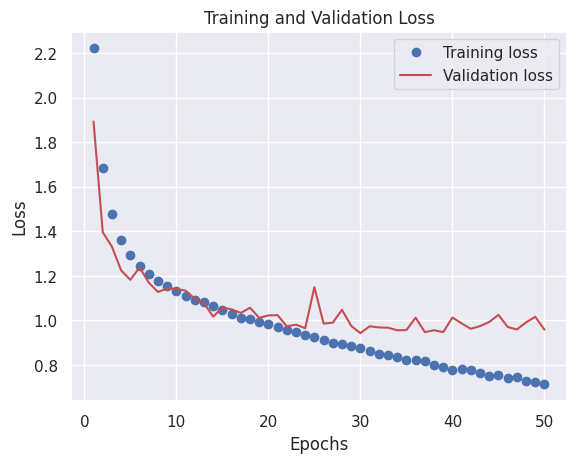

In [10]:
# Importing necessary library for plotting
import matplotlib.pyplot as plt

# Extracting loss history for training and validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Setting up the range for x-axis
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Setting up the title, labels, and legend
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Displaying the plot
plt.show()

### Training and validation accuracy curves

The following code block plots the training and validation accuracy over the epochs. The training accuracy is represented by red dots, while the validation accuracy is represented by a red line.

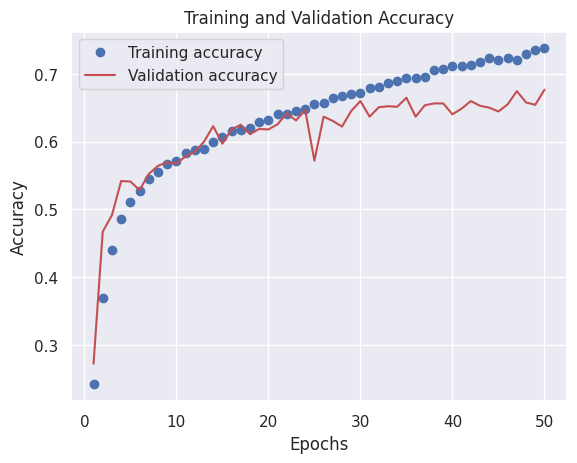

In [11]:
# Extracting accuracy history for training and validation
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation accuracy
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')

# Setting up the title, labels, and legend
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Displaying the plot
plt.show()

### Confusion Matrix

The following code block computes and plots the confusion matrix for the validation data. The confusion matrix provides a visual representation of the performance of the model, showing the true and predicted labels for each class.

23/23 [==============================] - 1s 28ms/step


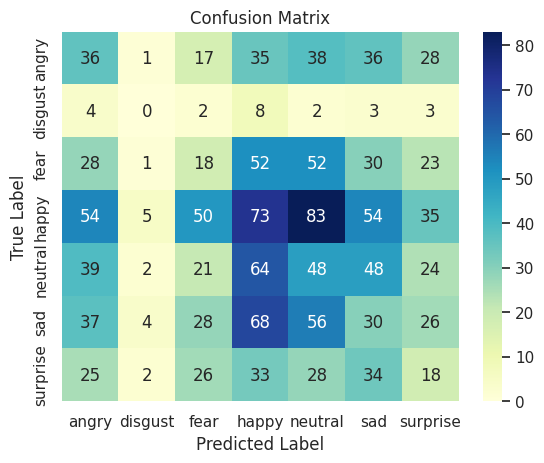

In [9]:
# Importing necessary libraries
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Getting the true labels and predicted labels for the validation data
val_labels = validation_gen.classes
val_pred_probs = model.predict(validation_gen)
val_pred_labels = np.argmax(val_pred_probs, axis=1)

# Computing the confusion matrix
confusion_mtx = confusion_matrix(val_labels, val_pred_labels)

# Setting up the class names
class_names = list(train_gen.class_indices.keys())

# Plotting the confusion matrix
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()